## Tutorial: cell type deconvolution for DLPFC dataset(10X visium and snRNA-seq)

In [1]:
import torch
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# from .util import permutation
import os
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import sys
sys.path.insert(1, '/home/nas2/biod/myy/project/CLPLS_package')
from CLPLS.util import *
from CLPLS.process import process_sc, process_st
from CLPLS.train import train,PLSR

In [3]:
epochs = 400
dim_input = 223 #input dimension
beta = 0.1 #positive loss hyperparam
random_seed = 11
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

#read data
st_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/DLPFC/adata_st.h5ad')
sadj, graph_neigh, label_CSL = process_st(st_adata)

sc_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/DLPFC/adata_rna.h5ad')
ctype_lab, fadj = process_sc(sc_adata, "celltype")

embedding_st, embedding_sc = train(dim_input=dim_input,hidden_channels=128,dim_output=50,st_adata=st_adata,graph_neigh=graph_neigh,spatial_graph=sadj,sc_adata=sc_adata,snn=fadj,ctype_lab=ctype_lab,label_CSL=label_CSL,epochs=epochs,beta=beta)

Graph with 3639 nodes and 10691 edges
[0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4]
[ 397  485 1059 ... 3579 3582 3615]
tensor([[ 397,  485, 1059,  ..., 2307, 2506, 3402],
        [   0,    0,    0,  ..., 3638, 3638, 3638]])
tensor([[    0,     0,     0,  ..., 11593, 11593, 11593],
        [   38,    74,    87,  ..., 11353, 11390, 11549]])
Begin to train ST data...


100%|██████████| 400/400 [00:57<00:00,  6.97it/s]


Optimization finished for ST data!
Training complete!
Embedding is saved 


In [4]:
df_projection = PLSR(sc_adata, st_adata, embedding_sc,embedding_st,component=5,label='celltype')

/home/moyuanyuan/anaconda3/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


[<Axes: title={'center': 'Ex_10_L2_4'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Ex_7_L4_6'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Ex_8_L5_6'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Oligos_1'}, xlabel='spatial1', ylabel='spatial2'>]

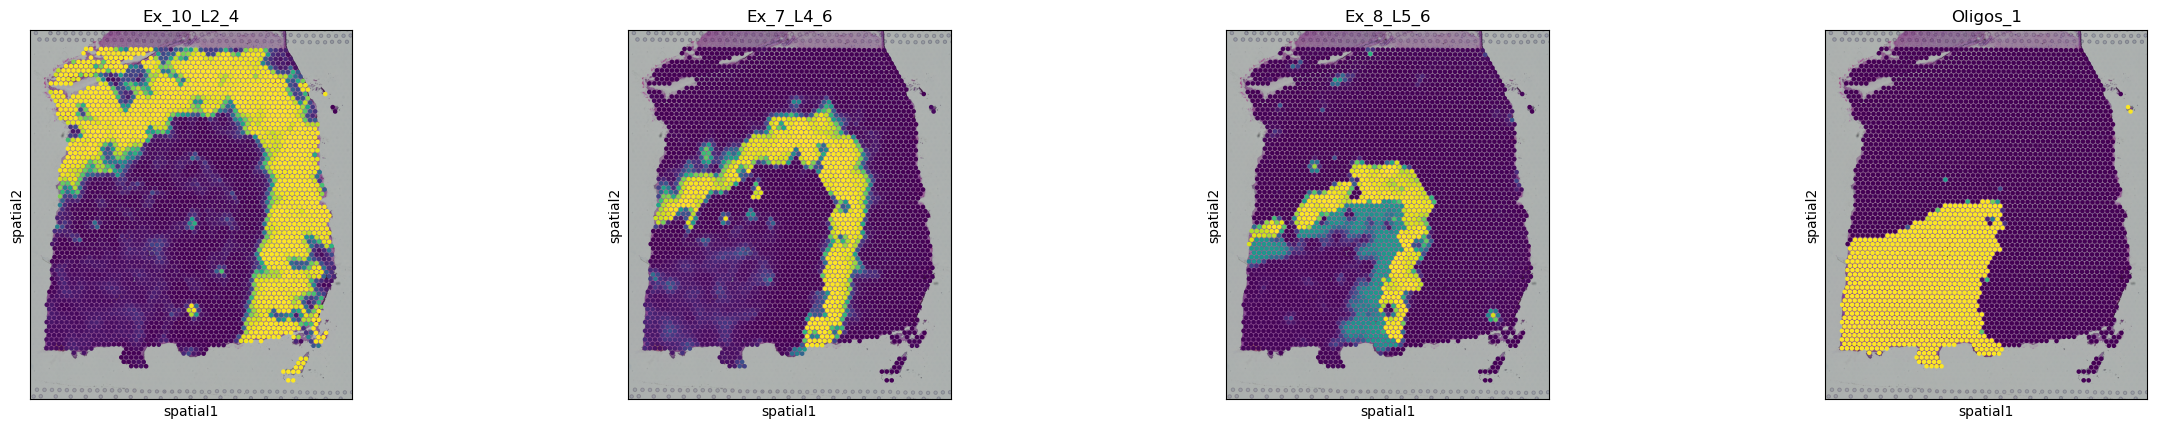

In [5]:
adata_st1 = st_adata.copy()
for i in range(6):
    adata_st1.obs[df_projection.columns.values[i]] = df_projection.values[:,i]
sc.pl.spatial(adata_st1,
                # selected cell types
                color=['Ex_10_L2_4', 'Ex_7_L4_6', 'Ex_8_L5_6','Oligos_1'],
                ncols=5, size=1.3,
                img_key='hires',
                # limit color scale at 99.2% quantile of cell abundance
                colorbar_loc=None,show=False             
                )